In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
#import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Activation
from qkeras import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h5 style="text-align: center;">{title}</h5>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

## Prepare dataset

### Load dataset

In [3]:
df1 = pd.read_csv('data/oct4_MCwithQuantInputs/InputTrainSet.csv')

In [4]:
df2 = pd.read_csv('data/oct4_MCwithQuantInputs/labelsTrain.csv')

In [5]:
df3 = pd.read_csv('data/oct4_MCwithQuantInputs/InputTestSet.csv')

In [6]:
df4 = pd.read_csv('data/oct4_MCwithQuantInputs/labelsTest.csv')

In [7]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print('Trainig set shape         :', X_train.shape) 
print('Trainig set shape (labels):', y_train.shape)
print('Test set shape:           :', X_test.shape)
print('Test set shape (labels)   :', y_test.shape)


Trainig set shape         : (792776, 14)
Trainig set shape (labels): (792776, 1)
Test set shape:           : (198196, 14)
Test set shape (labels)   : (198196, 1)


#### Visualize dataset

In [8]:
pd.DataFrame(X_test[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,0.0,4.0,5.0,5.0,7.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,-5.906050
1,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.082580
2,0.0,0.0,0.0,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127132
3,0.0,0.0,1.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.684330
4,0.0,0.0,0.0,0.0,0.0,6.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,-2.855120


### Scale dataset

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [10]:
pd.DataFrame(X_train).to_csv("csv/InputTrainSetScale.csv",index=False)
pd.DataFrame(X_test).to_csv("csv/InputTestSetScale.csv",index=False)

#### Visualize dataset post-scaling

In [11]:
pd.DataFrame(X_test[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.08375,-0.153563,2.262169,0.711550,0.010609,0.255980,0.003066,-0.129403,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,-1.302288
1,-0.08375,-0.153563,-0.370188,-0.622495,-0.860464,-0.807791,0.003066,-0.511937,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,1.798983
2,-0.08375,-0.153563,-0.370188,-0.622495,-0.337820,-0.098610,-0.177519,-0.511937,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,0.035265
3,-0.08375,-0.153563,0.287901,-0.355686,-0.337820,-0.453201,-0.538688,-0.511937,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,-1.474832
4,-0.08375,-0.153563,-0.370188,-0.622495,-0.860464,0.078685,0.905988,2.165804,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,-0.625898


In [12]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train, ', log2(min)=', log2_min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test, ', log2(min)=', log2_min_value_X_test)

X_train: max= 82.59475188891943 , log2(max)= 7 , min= -1.7786952735737245 , log2(min)= 1
X_test: max= 64.1270155482582 , log2(max)= 7 , min= -1.7793005128381305 , log2(min)= 1


### One-hot encoding

In [13]:
y_train_oh = pd.get_dummies(df2['ptLabel'])
y_test_oh = pd.get_dummies(df4['ptLabel'])

y_train_oh.to_csv("csv/labelsTrainOH.csv",index=False)
y_test_oh.to_csv("csv/labelsTestOH.csv",index=False)

In [14]:
display_side_by_side(pd.DataFrame(y_test[:5]), pd.DataFrame(y_test_oh[:5]), titles=['Prediction','One-hot encoding'])

Prediction 
 
 
 
 0 
 
 
 
 
 0 
 2 
 
 
 1 
 0 
 
 
 2 
 1 
 
 
 3 
 0 
 
 
 4 
 1 
 
 
 One-hot encoding 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 1 
 
 
 1 
 1 
 0 
 0 
 
 
 2 
 0 
 1 
 0 
 
 
 3 
 1 
 0 
 0 
 
 
 4 
 0 
 1 
 0

## Model (QKeras)

### Model definition

In [15]:
# prefix = ''
# def CreateQModel(shape, nb_classes):
#     x = x_in = Input(shape)
#     x = QDense(128,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense1")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = QActivation("quantized_relu(10,0)", name="relu1")(x)
#     x = QDense(3,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense2")(x)
#     x = Activation("softmax", name="softmax")(x)
#     model = Model(inputs=x_in, outputs=x)
#     return model

# Fold BatchNormalization in QDense
prefix = 'foldbatchnorm_'
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model = CreateQModel(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense1 (QDenseBatchnorm)     (None, 128)               2433      
_________________________________________________________________
relu1 (QActivation)          (None, 128)               0         
_________________________________________________________________
dense2 (QDense)              (None, 3)                 387       
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 2,820
Trainable params: 2,563
Non-trainable params: 257
_________________________________________________________________


### Model training

In [16]:
train_and_save = False

In [17]:
model_file = 'model/qkeras_' + prefix + 'model.h5'

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
    
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

### Model evaluation

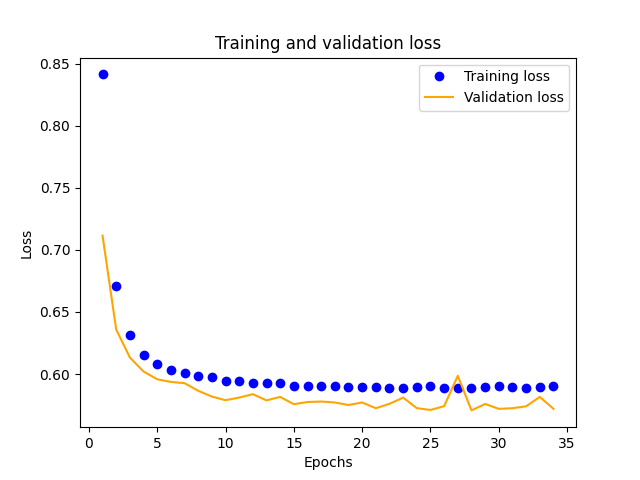

In [18]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + prefix + 'loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + prefix + 'loss.png')
    display(img)

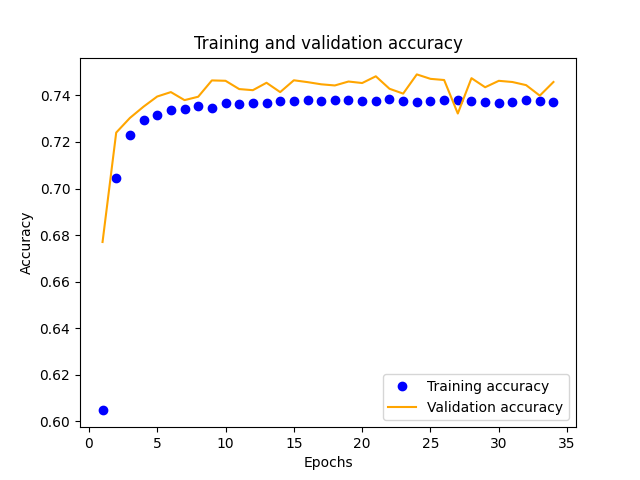

In [19]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + prefix + 'accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + prefix + 'accuracy.png')
    display(img)

In [20]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

In [21]:
pd.DataFrame(predictionsFiles).to_csv("csv/" + prefix + "predictionsFiles.csv", header='predict', index=False)

In [22]:
pd.DataFrame(y_test).to_csv("csv/true.csv", header='true', index=False)

In [23]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5649856925010681
Test accuracy: 0.7540717124938965


Confusion matrix:
[[80147  8858 10093]
 [15285 33822   442]
 [13955   109 35485]]


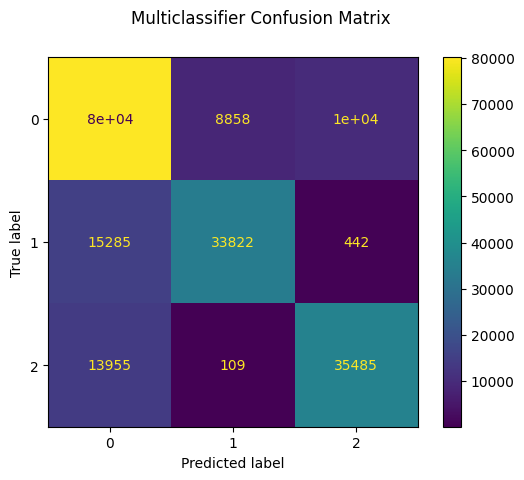

In [24]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + prefix + 'confusionMatrix.png')
plt.show()

## Hardware translation

### hls4ml configuration

In [25]:
import hls4ml
import plotting

/home/giuseppe/research/projects/fnal/CMS_PIX_28/hls4ml/hls4ml_finn_mlperftiny/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [26]:
print('hls4ml ver.', hls4ml.__version__)

hls4ml ver. 0.6.0


In [27]:
import os
os.environ['PATH'] = '/opt/xilinx/Vivado/2019.1/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


In [28]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

# hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
#     layers=['Activation'],
#     rounding_mode='AP_RND_CONV',
#     saturation_mode='AP_SAT')

hconfig = hls4ml.utils.config_from_keras_model(model, granularity='name')

hconfig['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
hconfig['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'

# for layer in hconfig['LayerName'].keys():
#     hconfig['LayerName'][layer]['Trace'] = True

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense1, layer type: QDenseBatchnorm
Layer name: relu1, layer type: QActivation
Layer name: dense2, layer type: QDense
Layer name: softmax, layer type: Activation


In [29]:
plotting.print_dict(hconfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  input_1
    Precision
      result:        ap_fixed<16,6>
  dense1
    Precision
      weight:        ap_fixed<5,1>
      bias:          ap_fixed<5,1>
    ReuseFactor:     1
  relu1
    Precision
      result:        ap_ufixed<10,0>
    ReuseFactor:     1
  dense2
    Precision
      weight:        ap_fixed<5,1>
      bias:          ap_fixed<5,1>
    ReuseFactor:     1
  softmax
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    exp_table_t:     ap_fixed<18,8>
    inv_table_t:     ap_fixed<18,4>


In [30]:
hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir='hls4ml_' + prefix + 'vivado_prj',
                                                    part='XC7A100T')

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 14]], output shape: [None, 14]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 14]], output shape: [None, 128]
Layer name: relu1, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: dense2, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 3]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model
shape: [3]
dims: ['N_LAYER_6']


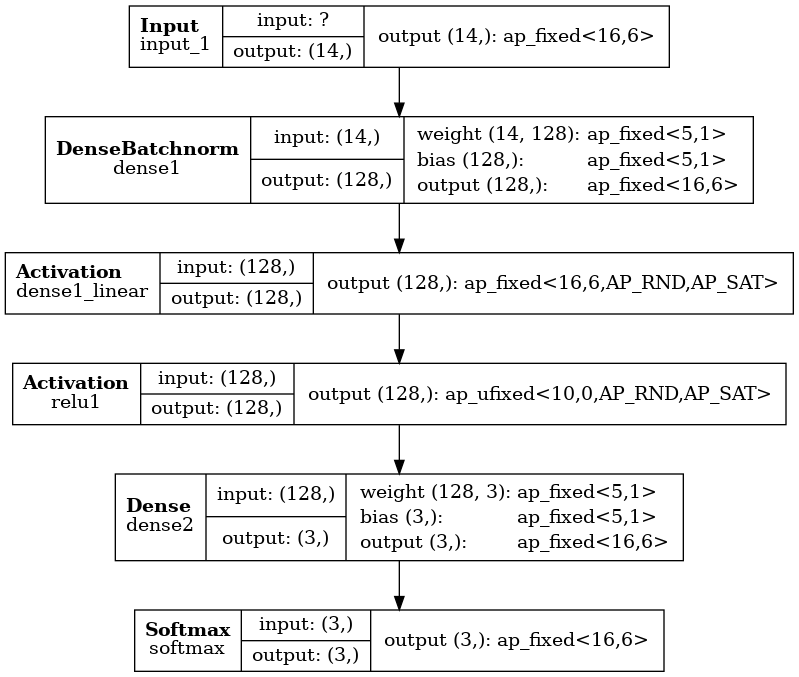

In [31]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file=None)

### Bit-accurate simulation

In [32]:
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = False

hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir='hls4ml_' + prefix + 'vivado_prj',
                                                    part='XC7A100T')

hmodel.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 14]], output shape: [None, 14]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 14]], output shape: [None, 128]
Layer name: relu1, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: dense2, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 3]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model
shape: [3]
dims: ['N_LAYER_6']
Writing HLS project
Done


In [33]:
hpreds = hmodel.predict(np.ascontiguousarray(X_test)) 

In [34]:
from sklearn.metrics import accuracy_score
print('-----------------------------------')
print("QKeras accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(preds, axis=1))))
print("hls4ml accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(hpreds, axis=1))))
print('-----------------------------------')

-----------------------------------
QKeras accuracy: 75.4072%
hls4ml accuracy: 75.3391%
-----------------------------------


In [35]:
display_side_by_side(pd.DataFrame(X_test[:5]), titles=['Scaled input'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.08375,-0.153563,2.262169,0.711550,0.010609,0.255980,0.003066,-0.129403,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,-1.302288
1,-0.08375,-0.153563,-0.370188,-0.622495,-0.860464,-0.807791,0.003066,-0.511937,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,1.798983
2,-0.08375,-0.153563,-0.370188,-0.622495,-0.337820,-0.098610,-0.177519,-0.511937,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,0.035265
3,-0.08375,-0.153563,0.287901,-0.355686,-0.337820,-0.453201,-0.538688,-0.511937,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,-1.474832
4,-0.08375,-0.153563,-0.370188,-0.622495,-0.860464,0.078685,0.905988,2.165804,-0.247129,-0.099096,-0.074897,-0.063919,-0.056348,-0.625898


In [36]:
display_side_by_side(pd.DataFrame(y_test[:5]),
                     pd.DataFrame(y_test_oh[:5]),
                     pd.DataFrame(preds[:5]),
                     pd.DataFrame(hpreds[:5]),
                     titles=['Expected prediction','Expected prediction (one-hot enc.)', 'QKeras prediction', 'hls4ml prediction'])

Expected prediction 
 
 
 
 0 
 
 
 
 
 0 
 2 
 
 
 1 
 0 
 
 
 2 
 1 
 
 
 3 
 0 
 
 
 4 
 1 
 
 
 Expected prediction (one-hot enc.) 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0 
 0 
 1 
 
 
 1 
 1 
 0 
 0 
 
 
 2 
 0 
 1 
 0 
 
 
 3 
 1 
 0 
 0 
 
 
 4 
 0 
 1 
 0 
 
 
 QKeras prediction 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0.619311 
 0.004759 
 0.375929 
 
 
 1 
 0.587351 
 0.274615 
 0.138034 
 
 
 2 
 0.841295 
 0.139305 
 0.019400 
 
 
 3 
 0.694501 
 0.252023 
 0.053476 
 
 
 4 
 0.225978 
 0.773628 
 0.000394 
 
 
 hls4ml prediction 
 
 
 
 0 
 1 
 2 
 
 
 
 
 0 
 0.623047 
 0.003906 
 0.402344 
 
 
 1 
 0.686523 
 0.304688 
 0.163086 
 
 
 2 
 0.874023 
 0.142578 
 0.019531 
 
 
 3 
 0.780273 
 0.268555 
 0.059570 
 
 
 4 
 0.225586 
 0.788086 
 0.000000

### Synthesis

In [37]:
# This cell applies a patch/workaround necessary with some version of hls4ml.
# It is a poor solution, but it works. Edit patches/project.tcl if you make any change
# in this notebook.
import shutil
_ = shutil.copyfile('patches/project.tcl', 'hls4ml_' + prefix + 'vivado_prj/project.tcl')

In [38]:
%%time
results = hmodel.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'giuseppe' on host 'thorin' (Linux_x86_64 version 5.14.0-1048-oem) on Sat Oct 22 20:34:59 PDT 2022
INFO: [HLS 200-10] On os Ubuntu 22.04.1 LTS
INFO: [HLS 200-10] In directory '/home/giuseppe/research/projects/fnal/CMS_PIX_28/directional-pixel-detectors/multiclassifier/hls4ml_foldbatchnorm_vivado_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/giuseppe/research/projects/fnal/CMS_PIX_28/directional-pixel-detectors/multiclassifier/hls4ml_foldbatchno

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config7>' (firmware/nnet_utils/nnet_activation.h:224:45).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config4>' (firmware/nnet_utils/nnet_activation.h:71:39).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::linear<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, linear_config3>' (firmware/nnet_utils/nnet_activation.h:51:39).
INFO: [XFORM 203

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:72) by setting 'weights.V' to 'w5.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:72) by setting 'biases[0].V' to 'b5.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<10, 

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[19].V' to 'b2.V.19'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[20].V' to 'b2.V.20'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fix

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[39].V' to 'b2.V.39'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[54].V' to 'b2.V.54'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_f

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[69].V' to 'b2.V.69'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[85].V' to 'b2.V.85'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[97].V' to 'b2.V.97'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[108].V' to 'b2.V.108'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[120].V' to 'b2.V.120'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (a

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:01:09 ; elapsed = 00:01:11 . Memory (MB): peak = 4337.172 ; gain = 3618.188 ; free physical = 35618 ; free virtual = 48904
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 71.98 seconds; current allocated memory: 415.311 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 2.32 seconds; current allocated memory: 466.868 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' is 6733 from HDL expression: ((1'b1 == ap_ce_reg) & (1'b0 == ap_block_pp0_stage0_11001))
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 1.86 second

In [39]:
print('-----------------------------------')
#print(results) # Print hashmap
hls_results=results
#['CSynthesisReport'] 
print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
print("BRAM_18K:               {}, {:0.1f}% (Aval. {})".format(hls_results['BRAM_18K'], int(hls_results['BRAM_18K'])*100.0/int(hls_results['AvailableBRAM_18K']), hls_results['AvailableBRAM_18K']))
print("DSP48E:                 {}, {:0.1f}% (Aval. {})".format(hls_results['DSP48E'], int(hls_results['DSP48E'])*100.0/int(hls_results['AvailableDSP48E']), hls_results['AvailableDSP48E']))
print("FF:                     {}, {:0.1f}% (Aval. {})".format(hls_results['FF'], int(hls_results['FF'])*100.0/int(hls_results['AvailableFF']), hls_results['AvailableFF']))
print("LUT:                    {}, {:0.1f}% (Aval. {})".format(hls_results['LUT'], int(hls_results['LUT'])*100.0/int(hls_results['AvailableLUT']), hls_results['AvailableLUT']))
#print("URAM:                   {}, {} (Aval. {})".format(hls_results['URAM'], int(hls_results['URAM'])*100.0/int(hls_results['AvailableURAM']), hls_results['AvailableURAM']))
print('-----------------------------------')

-----------------------------------
Estimated Clock Period: 8.401 ns
Best/Worst Latency:     10 / 10
Interval Min/Max:       1 / 1
BRAM_18K:               3, 1.1% (Aval. 270)
DSP48E:                 24, 10.0% (Aval. 240)
FF:                     15070, 11.9% (Aval. 126800)
LUT:                    59747, 94.2% (Aval. 63400)
-----------------------------------
